# Object Detection Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/02-object-detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [2]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File ‘00-start-eva-server.ipynb’ already there; not retrieving.

nohup eva_server >> eva.log 2>&1 &
('04-29-2023 21:53:19 WARNING[create_udf_executor:create_udf_executor.py:exec:0101] UDF FastRCNNObjectDetector already exists, nothing added.\n', '04-29-2023 21:53:19 WARNING[create_udf_executor:create_udf_executor.py:exec:0101] UDF ArrayCount already exists, nothing added.\n', '04-29-2023 21:53:19 WARNING[create_udf_executor:create_udf_executor.py:exec:0101] UDF Crop already exists, nothing added.\n')
('04-29-2023 21:53:19 WARNING[create_udf_executor:create_udf_executor.py:exec:0101] UDF Open already exists, nothing added.\n', '04-29-2023 21:53:19 WARNING[create_udf_executor:create_udf_executor.py:exec:0101] UDF Similarity already exists, nothing added.\n', '04-29-2023 21:53:19 WARNING[create_udf_executor:create_udf_executor.py:exec:0101] UDF YoloV5 already exists, nothing added.\n')

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: pip install --upg

### Download the Videos

In [3]:
# Getting the video files
!wget -nc https://www.dropbox.com/s/k00wge9exwkfxz6/ua_detrac.mp4?raw=1 -O ua_detrac.mp4
# Getting the Yolo object detector
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/yolo_object_detector.py

--2023-04-29 21:53:55--  https://www.dropbox.com/s/k00wge9exwkfxz6/ua_detrac.mp4?raw=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/k00wge9exwkfxz6/ua_detrac.mp4 [following]
--2023-04-29 21:53:55--  https://www.dropbox.com/s/raw/k00wge9exwkfxz6/ua_detrac.mp4
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc77172ec955026f38048b1387d.dl.dropboxusercontent.com/cd/0/inline/B7EjDas4NK35sQGCdahsRYM2UD5fmzhjzs2rU4TCKtaEnW1eWi8wlyrf8fkE-8KUO051UKJNoRHXdkWaFwLXfmnGwbEy5j97MZWjUCL20YDRcNEMppXbY-SDS32HJTG3HGu1n77mY0wnGiFpr6ozrHja30D2dl2drI8UwImERM8z-w/file# [following]
--2023-04-29 21:53:56--  https://ucc77172ec955026f38048b1387d.dl.dropboxusercontent.com/cd/0/inline/B7EjDas4NK35sQGCdahsRYM2UD5fmzhjzs2rU4TCKtaEnW1eWi8wlyrf8fkE-8KUO051UKJ

### Load the surveillance videos for analysis

##### We use regular expression to load all the videos into the table

In [4]:
cursor.execute('DROP TABLE ObjectDetectionVideos')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD VIDEO "ua_detrac.mp4" INTO ObjectDetectionVideos;')
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                                    0
0  Table Successfully dropped: ObjectDetectionVideos
@query_time: 0.056383105998975225
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded VIDEO: 1
@query_time: 0.11677601099654566


### Visualize Video

In [5]:
from IPython.display import Video
Video("ua_detrac.mp4", embed=True)

### Register YOLO Object Detector an an User-Defined Function (UDF) in EVA 

In [6]:
cursor.execute("""DROP UDF Yolov8
      """)
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                  0
0  UDF Yolov8 successfully dropped
@query_time: 0.023056960002577398


In [8]:
cursor.execute("""CREATE UDF IF NOT EXISTS Yolov8
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
                scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  '/home/vagrant/eva_fork/eva/eva/udfs/yolov8_object_detector.py';
      """)
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                                 0
0  UDF Yolov8 successfully added to the database.
@query_time: 3.458555912999145


### Run Object Detector on the video

In [9]:
cursor.execute("""SELECT id, Yolov8(data)
                  FROM ObjectDetectionVideos 
                  WHERE id < 20""")
response = cursor.fetch_all()
response.as_df()

objectdetectionvideos.id   
0                          0  \
1                          1   
2                          2   
3                          3   
4                          4   
5                          5   
6                          6   
7                          7   
8                          8   
9                          9   
10                        10   
11                        11   
12                        12   
13                        13   
14                        14   
15                        15   
16                        16   
17                        17   
18                        18   
19                        19   

                                        yolov8.labels   
0   [car, car, car, car, car, car, car, car, car, ...  \
1   [car, car, car, car, car, car, car, car, car, ...   
2   [car, car, car, car, car, car, car, car, car, ...   
3   [car, car, car, car, car, car, car, car, car, ...   
4   [car, car, car, car, car, car, car, car, car, ...   
5   [car, car, car, car, car, car, car, car, perso...   
6   [car, car, car, car, car, car, car, car, car, ...   
7   [car, car, car, car, car, car, car, car, car, ...   
8   [car, car, car, car, car, car, car, car, perso...   
9   [car, car, car, car, car, car, car, car, car, ...   
10  [car, car, car, car, car, car, car, car, car, ...   
11  [car, car, car, car, car, car, car, car, car, ...   
12  [car, car, car, car, car, car, car, car, car, ...   
13  [car, car, car, car, car, car, car, car, car, ...   
14  [car, car, car, car, car, car, car, car, car, ...   
15  [car, car, car, car, car, car, car, car, car, ...   
16  [car, car, car, car, car, car, car, car, motor...   
17  [car, car, car, car, car, car, car, car, car, ...   
18  [car, car, car, car, car, car, car, car, car, ...   
19  [car, car, car, car, car, car, car, car, car, ...   

                                        yolov8.bboxes   
0   [[827.0, 277.0, 959.0, 360.0], [614.0, 216.0, ...  \
1   [[831.0, 278.0, 959.0, 361.0], [616.0, 216.0, ...   
2   [[834.0, 279.0, 959.0, 363.0], [617.0, 217.0, ...   
3   [[839.0, 280.0, 959.0, 364.0], [618.0, 218.0, ...   
4   [[843.0, 281.0, 959.0, 364.0], [621.0, 218.0, ...   
5   [[846.0, 282.0, 959.0, 363.0], [622.0, 219.0, ...   
6   [[849.0, 284.0, 959.0, 360.0], [624.0, 220.0, ...   
7   [[626.0, 219.0, 738.0, 282.0], [855.0, 284.0, ...   
8   [[628.0, 220.0, 739.0, 283.0], [859.0, 285.0, ...   
9   [[629.0, 221.0, 741.0, 284.0], [864.0, 287.0, ...   
10  [[631.0, 223.0, 745.0, 285.0], [868.0, 287.0, ...   
11  [[871.0, 288.0, 959.0, 356.0], [633.0, 223.0, ...   
12  [[874.0, 289.0, 959.0, 356.0], [635.0, 222.0, ...   
13  [[881.0, 290.0, 959.0, 356.0], [171.0, 408.0, ...   
14  [[638.0, 225.0, 755.0, 292.0], [174.0, 404.0, ...   
15  [[640.0, 225.0, 758.0, 293.0], [888.0, 292.0, ...   
16  [[641.0, 226.0, 760.0, 293.0], [892.0, 292.0, ...   
17  [[644.0, 227.0, 763.0, 294.0], [895.0, 293.0, ...   
18  [[646.0, 227.0, 768.0, 294.0], [901.0, 295.0, ...   
19  [[648.0, 227.0, 771.0, 294.0], [906.0, 297.0, ...   

                                        yolov8.scores  
0   [0.89, 0.84, 0.8, 0.79, 0.74, 0.69, 0.65, 0.64...  
1   [0.88, 0.85, 0.82, 0.78, 0.78, 0.76, 0.71, 0.7...  
2   [0.88, 0.84, 0.81, 0.77, 0.77, 0.74, 0.71, 0.7...  
3   [0.88, 0.85, 0.84, 0.77, 0.75, 0.75, 0.73, 0.7...  
4   [0.88, 0.87, 0.84, 0.79, 0.76, 0.75, 0.74, 0.7...  
5   [0.87, 0.86, 0.77, 0.76, 0.74, 0.69, 0.68, 0.6...  
6   [0.87, 0.86, 0.79, 0.79, 0.77, 0.68, 0.68, 0.6...  
7   [0.88, 0.88, 0.81, 0.78, 0.71, 0.69, 0.68, 0.6...  
8   [0.88, 0.86, 0.81, 0.72, 0.67, 0.66, 0.63, 0.6...  
9   [0.87, 0.86, 0.81, 0.81, 0.7, 0.68, 0.67, 0.67...  
10  [0.86, 0.85, 0.84, 0.81, 0.71, 0.71, 0.68, 0.6...  
11  [0.85, 0.85, 0.81, 0.75, 0.71, 0.7, 0.67, 0.67...  
12  [0.85, 0.85, 0.82, 0.81, 0.75, 0.68, 0.67, 0.6...  
13  [0.88, 0.86, 0.85, 0.79, 0.72, 0.68, 0.68, 0.6...  
14  [0.89, 0.87, 0.87, 0.78, 0.72, 0.67, 0.66, 0.6...  
15  [0.89, 0.87, 0.76, 0.7, 0.7, 0.67, 

### Visualizing output of the Object Detector on the video

In [12]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    while ret:
        df = detections
        df = df[['yolov8.bboxes', 'yolov8.labels']][df.index == frame_id]
        if df.size:
            dfLst = df.values.tolist()
            for bbox, label in zip(dfLst[0][0], dfLst[0][1]):
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                # object bbox
                frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 
                # object label
                cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness) 
                # frame label
                cv2.putText(frame, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness) 
            video.write(frame)

            # Stop after twenty frames (id < 20 in previous query)
            if frame_id == 20:
                break

            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(frame)
                plt.show()

        
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

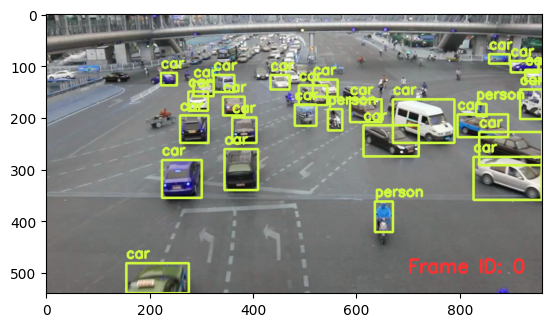

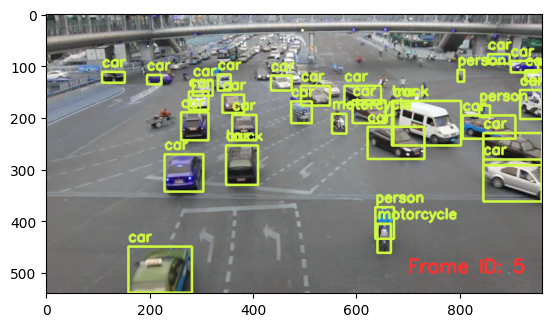

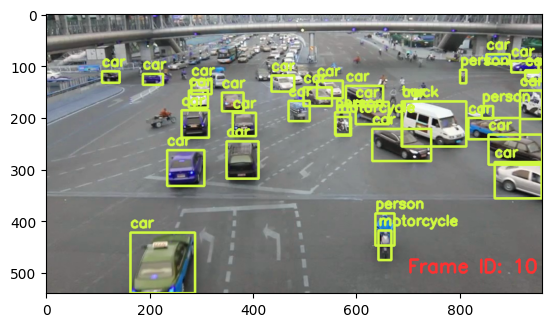

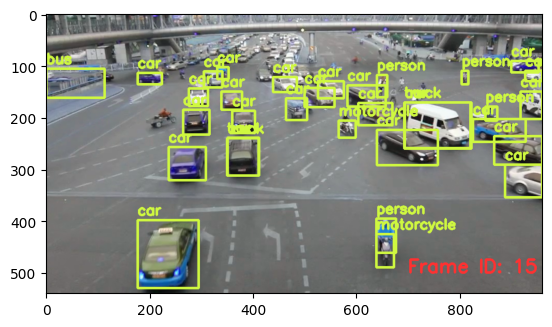

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\x0bZN...')

In [13]:
from ipywidgets import Video, Image
input_path = 'ua_detrac.mp4'
output_path = 'video.mp4'

dataframe = response.as_df()
annotate_video(dataframe, input_path, output_path)
Video.from_file(output_path)

### Dropping an User-Defined Function (UDF)

In [9]:
cursor.execute("DROP UDF YoloV8;")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                  0
0  UDF YoloV5 successfully dropped
@query_time: 0.030457920999992893
